In [1]:
# Import the required modules
import cv2
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np
import tensorflow as tf

In [2]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def showarray(a, prev_display_id=None, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    if prev_display_id is not None:
        IPython.display.update_display(obj, display_id=prev_display_id)
        return prev_display_id
    else:
        return IPython.display.display(obj, display_id=True)

In [3]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="mobilenet_v1_1.0_224_quant.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = interpreter.get_input_details()[0]["index"]

# Load labels
with open("labels_mobilenet_quant_v1_224.txt", 'r') as f:
    labels = f.read().splitlines() 

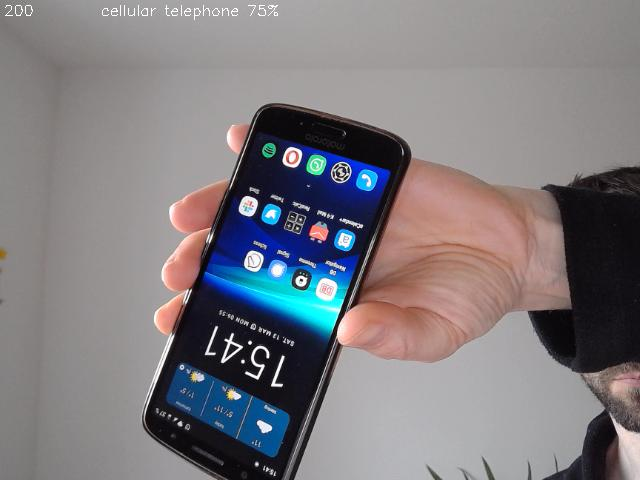

In [4]:
# Read the image and decode to a tensor
vc = cv2.VideoCapture(0)

display_id = None

if vc.isOpened(): # try to get the first frame
    try:
        for i in range(200):
            _, frame = vc.read()
            
            # Convert the image from OpenCV BGR format to matplotlib RGB format
            # to display the image
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)        
            
            frame_squared = frame_rgb[0:480, 80:480+80] 
            frame_small = cv2.resize(frame_squared,(224, 224))
            #Preprocess the image to required size and cast
            input_shape = input_details[0]['shape']
            input_tensor= np.array(np.expand_dims(frame_small,0), dtype=np.uint8)            


            # Run inference
            interpreter.set_tensor(input_index, input_tensor)

            #Run the inference
            interpreter.invoke()
            output_details = interpreter.get_output_details()[0]
            output = np.squeeze(interpreter.get_tensor(output_details['index']))

            if output_details['dtype'] == np.uint8:
                scale, zero_point = output_details['quantization']
                output = scale * (output - zero_point)   

            ordered = np.argpartition(-output, 1)

            result = frame_rgb
            cv2.putText(result, str(i+1), (3, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (255, 255, 255), 1)

            if output[ordered[0]] > 0.:
                class_text = '{} {:.0f}%'.format(labels[ordered[0]], output[ordered[0]]*100) 
                cv2.putText(result, class_text, (100, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (255, 255, 255), 1)
            
            if display_id is not None:
                showarray(result, display_id)
            else:
                display_id = showarray(result).display_id
                
            # Display the frame info until new frame is available
            IPython.display.clear_output(wait=True)
    finally:
        vc.release()
else:
    is_capturing = False
    print("Camera not found!")